In [51]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import glob
import pandas as pd

In [2]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='10GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/scratch/djk2120/workers/', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='01:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(30)

# Setup your client
client = Client(cluster)

/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.11/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.11/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


In [3]:
def amean(da):
    #annual mean
    m  = da['time.daysinmonth']
    xa = 1/365*(m*da).groupby('time.year').sum().compute()
    xa.name=da.name
    xa.attrs=da.attrs
    return xa

def gmean(da,la):
    x=1/la.sum()*(da*la).sum(dim=['lat','lon']).compute()
    x.name=da.name
    x.attrs=da.attrs
    return x

def pp(ds):
    dvs=['TLAI','GPP','NBP','TOTVEGC','TOTSOMC']
    return ds[dvs]

In [4]:
x='/glade/scratch/djk2120/archive/TRENDY2023_f09_{}/lnd/hist/*h0*'
dsets={sim:xr.open_mfdataset(sorted(glob.glob(x.format(sim))),
                             combine='by_coords',
                             parallel=True,
                             preprocess=pp)
       for sim in ['S0','S1','S2','S3']}
for sim in dsets:
    dsets[sim]['time']=xr.cftime_range('1701',periods=len(dsets[sim].time),freq='MS',calendar='noleap')
    
ds=xr.concat([dsets[sim] for sim in dsets],dim='sim')
ds['sim']=[sim for sim in dsets]

In [77]:
x='/glade/scratch/djk2120/archive/TRENDY2023_f09_{}/lnd/hist/*h0*'
f=glob.glob(x.format('S0'))[0]
tmp=xr.open_dataset(f)
laglobal=tmp.area*tmp.landfrac

In [10]:
lat=tmp.lat
la={'Global':laglobal,
    'North':laglobal.where(lat>30),
    'Tropics':laglobal.where(abs(lat)<30),
    'South':laglobal.where(lat<-30)}

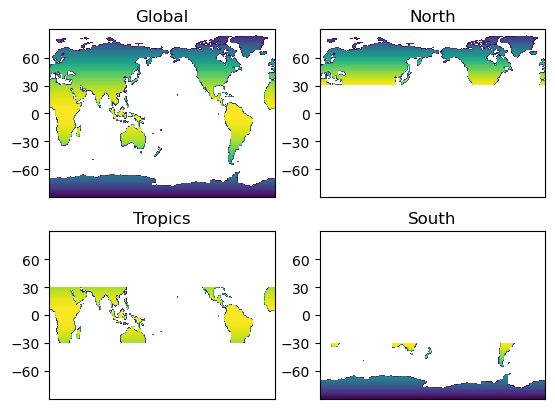

In [26]:
for i,region in enumerate(la):
    plt.subplot(2,2,i+1)
    la[region].plot(add_colorbar=False)
    plt.title(region)
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks([])
    plt.yticks(-60+30*np.arange(5))

In [35]:
xs={}
for region in la:
    a=la[region]
    cf=24*60*60*365*1e-9*a.sum()
    xs[region]=cf*amean(gmean(ds.NBP,a))

/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 21.81 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 21.81 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 21.81 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 21.81 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and usin

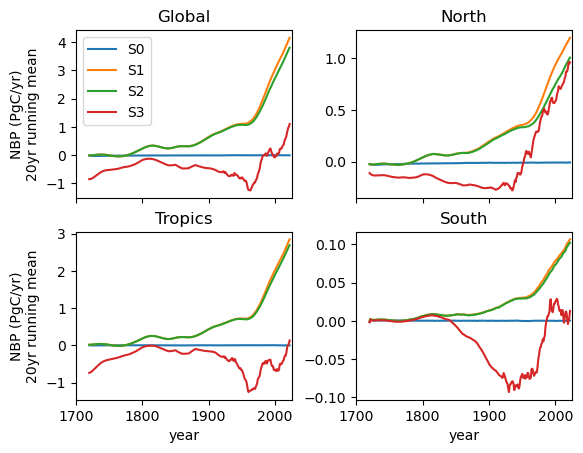

In [79]:
for i,region in enumerate(xs):
    plt.subplot(2,2,i+1)
    plt.plot(xs[region].year,xs[region].rolling({'year':20}).mean())
    plt.xlim([1700,2025])
    if i%2==0:
        plt.ylabel('NBP (PgC/yr)\n20yr running mean')
    plt.title(region)
    if i<2:
        plt.xticks(1700+100*np.arange(4),[])
    else:
        plt.xlabel('year')
plt.subplot(221)
plt.legend(ds.sim.values)
plt.subplots_adjust(wspace=0.3)
plt.savefig('TRENDYv12_CLM5.0_NBP.png',dpi=300,bbox_inches='tight')

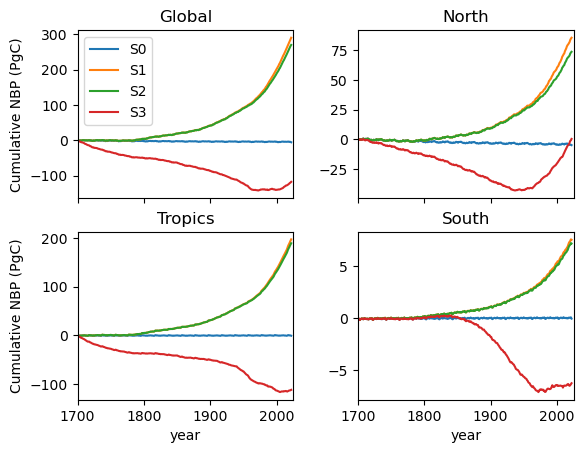

In [80]:
for i,region in enumerate(xs):
    plt.subplot(2,2,i+1)
    plt.plot(xs[region].year,xs[region].cumsum(dim='year'))
    plt.xlim([1700,2025])
    if i%2==0:
        plt.ylabel('Cumulative NBP (PgC)')
    plt.title(region)
    if i<2:
        plt.xticks(1700+100*np.arange(4),[])
    else:
        plt.xlabel('year')
plt.subplot(221)
plt.legend(ds.sim.values)
plt.subplots_adjust(wspace=0.3)
plt.savefig('TRENDYv12_CLM5.0_NBPcumulative.png',dpi=300,bbox_inches='tight')

In [73]:
yr=xs['Global'].year.values
for sim in ds.sim:
    df=pd.DataFrame({region:xs[region].sel(sim=sim) for region in xs},index=yr)
    df.index.name='Year'
    f='CLM5.0_{}_zonalNBP.txt'.format(str(sim.values))
    df.to_csv(f)